# TP : Proximal coordinate descent method on regression models

#### Authors: S. Gaiffas, A. Gramfort

## Aim

The aim of this material is to code 
- proximal coordinate descent

for 
- Lasso / L1 linear regression
- non-negative least squares (NNLS)

models.

The proximal operators we will use are the 
- L1 penalization
- indicator function of $\mathbb{R}_+$

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 23th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 17 octobre 2016**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [16]:
# Change here using YOUR first and last names
fn1 = "hospice"
ln1 = "dossou-yovo"
fn2 = "olivier"
ln2 = "aguillon"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_cd", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_cd_dossou-yovo_hospice_and_aguillon_olivier.ipynb


In [17]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse positive vectors and simulating data

### Getting sparse coefficients

In [18]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

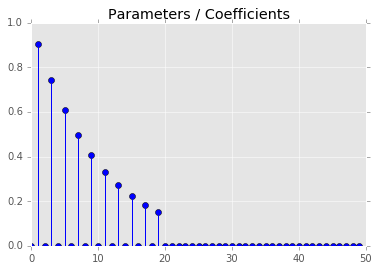

In [19]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = (idx % 2) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [20]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    
    return A, b

## Proximal operators and Solver


We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(y, t) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + t g(x) \Big\}.
$$

where $t \geq 0$ is a non-negative number.
We have in mind to use the following cases

- Lasso penalization, where $g(x) = s \|x\|_1$
- Indicator function of $\mathbb{R}_+$, where $g(x) = i_{x \geq 0}(\cdot)$

where $s \geq 0$ is a regularization parameter.

We want to minimize:
$$
\arg\min_x F(x)
$$
with
$$
 F(x) = \frac{1}{2} \|b - Ax\|^2 + g(x)
$$

## Questions

- Code a function that computes $g(x)$ and $\text{prox}_g(x)$ for in both cases
- Justify why proximal coordinate descent can be applied to obtain a minimum of such objective functions.
- Starting from the code provided in the notebook presented during the coordinate descent course as well as the code below, implement a proximal coordinate method for both penalties.
- Evaluate qualitatively the convergence when varying the conditioning of the problem.
- Bonus: Try to show that coordinate is much less affected by bad conditioning that proximal gradient descent.

### You are expected to implement the smart residuals updates !

### You are very welcome to reuse everything you did for TP1 !


## Code a function that computes $g(x)$ and $\text{prox}_g(x)$ for in both cases
** Lasso**

In [21]:
# Define g(x)
def lasso(x, s):
    """Value of the Lasso penalization at x with strength t"""
    return s*np.linalg.norm(x, 1)

# Define proxg(x)
def prox_lasso(x, s, t=1.):
    """Proximal operator for the Lasso at x with strength t"""
    return np.multiply(np.sign(x), np.maximum(np.absolute(x) - s*t, 0))

**Indicator function**

In [22]:
def indicator(x, s):
    """Value of the indicator function of R+ penalisation at x with strength s"""
    if s == 0:
        return 0
    return np.inf if any(x < 0) else 0

def prox_indicator(x, s, t=1.):
    """Proximal operator for indicator function of R+ at x with strength s"""
    return x if t*s == 0 else np.maximum(x, 0)

## Justify why proximal coordinate descent can be applied to obtain a minimum of such objective functions

proximal coordinate descent can be applied to obtain a minimum of such objective functions because:

- $F$ is strickly convex, 
- $F$ is continuously differentiable and $\nabla f$ is Lipschitz,
- each $\text{g}$ is convex.

## Starting from the code provided in the notebook presented during the coordinate descent course as well as the code below, implement a proximal coordinate method for both penalties

In [23]:
def cd_linreg(x0, A, b, g, prox_g, s=0., n_iter=50, x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm

    Minimize :
    
    1/2 ||b−Ax||^2 + s * g(x)
    
    with coodinate descent.
    """
   
    x_new  = np.array([])
    x  = np.array([])
    
    
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape
    
    r = b - A.dot(x)

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = 0.5 * np.linalg.norm(b - A.dot(x))**2 + g(x, s)
    objectives.append(obj)
    
    #Define Lipschitz constant
    Li = np.sum(A * A, axis=0)
    
    
    if verbose:
        print("Lauching Coordinate Descent solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))

            
    for k in range(n_iter + 1):
        #### TODO ####
        i = k % n_features
      
        x_new[i] += A[:, i].T.dot(r) / Li[i]
        x_new[i] = prox_g(x_new[i], s, 1/Li[i])
        r -= (x_new[i] - x[i]) * A[:, i]
        x[i] = x_new[i]

                
        obj = 0.5 * np.linalg.norm(b - A.dot(x))**2 + g(x, s)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
           print(' | '.join([("%d" % k).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8)]))       
    
    return x, objectives, errors

## Evaluate qualitatively the convergence when varying the conditioning of the problem

**1. STUDY BASED ON THE TUNING OR SMOOTHING PARAMETER (THAT BALANCES GOODNESS-OF-FIT AND PENALIZATION)**

This study consists of visualizing the possible changes the smoothing parameter on the objectives and the errors of the lasso  and indicator function.

C:\Users\Olivier\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


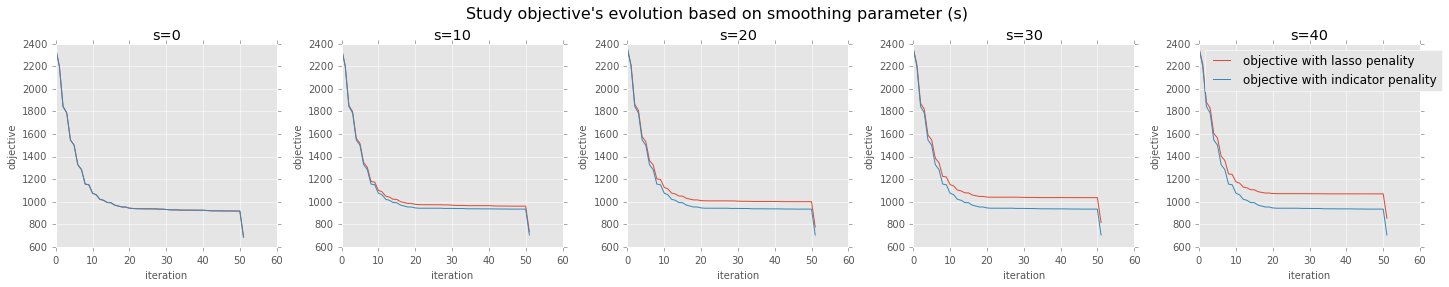

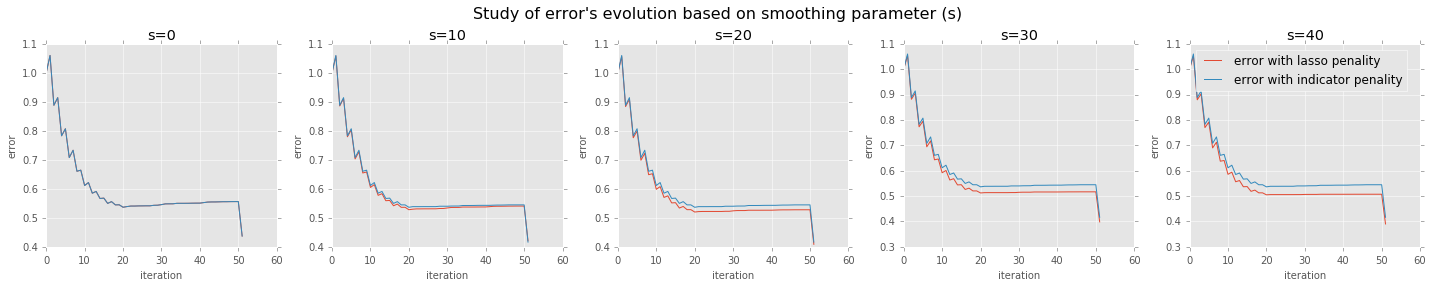

In [24]:
"""Evolution of tuning or smoothing parameter, that balances goodness-of-fit and penalization"""


"""Phase 1.1: Initialization"""
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
x0 = np.zeros(n_features)
   
k=5
obj_l  = np.array([])          #objective's Lasso
err_l  = np.array([])          #error's Lasso
obj_i  = np.array([])          #objective's indicator function
err_i  = np.array([])          #error's indicator function

obj_li  = np.array([])         #observation of objective's Lasso
err_li  = np.array([])         #observation of error's Lasso
obj_ii  = np.array([])         #observation of objective's indicator function
err_ii  = np.array([])         #observation of error's indicator function


"""Phase 1.2: Incrementing variables"""

for i in range(k):
    s=i*10
      
    _, obj_li, err_li = cd_linreg(x0, A, b, lasso, prox_lasso, s, n_iter=50,x_true=coefs, verbose=False)
    _, obj_ii, err_ii = cd_linreg(x0, A, b, indicator, prox_indicator, s, n_iter=50,x_true=coefs, verbose=False)

    obj_l=np.append(obj_l,obj_li)      #Incremantation of a matrix of objective's Lasso
    err_l=np.append(err_l,err_li)      #Incremantation of a matrix of observation of error's Lasso
    obj_i=np.append(obj_i,obj_ii)      #Incremantation of a matrix of observation of objective's indicator function
    err_i=np.append(err_i,err_ii)      #Incremantation of a matrix of observation of error's indicator function

    #Reshape matrix
err_l = err_l.reshape(k,len(err_li))
obj_l = obj_l.reshape(k,len(obj_li))
err_i = err_i.reshape(k,len(err_ii))
obj_i = obj_i.reshape(k,len(obj_ii))


"""Phase 1.3: Plot observation based on smoothing parameter"""

plt.style.use('ggplot')    # sortie graphique améliorées

    # Graphic objective functions
fig, axs = plt.subplots(ncols=k, figsize=(20, 4))
plt.suptitle("Study objective's evolution based on smoothing parameter (s)", fontsize=16)
for i in range(k): 
    s=i*10
    axs.flat[i].plot(np.arange(len(obj_l[i])),obj_l[i], label="objective with lasso penality")
    axs.flat[i].plot(np.arange(len(obj_i[i])),obj_i[i], label="objective with indicator penality")
    axs.flat[i].set_xlabel("iteration",fontsize = 10)
    axs.flat[i].set_ylabel("objective",fontsize = 10)
    axs.flat[i].set_title("s=%s" %s)
    plt.legend(loc=2,prop={'size':12})
    
    
plt.tight_layout()                 # Pour espacer les schémas  
plt.subplots_adjust(top=0.85)
plt.show()


    # Graphic error functions
fig, axs = plt.subplots(ncols=k, figsize=(20, 4))
plt.suptitle("Study of error's evolution based on smoothing parameter (s)", fontsize=16)  

for i in range(k): 
    s=i*10
    axs.flat[i].plot(np.arange(len(err_l[i])),err_l[i], label="error with lasso penality")
    axs.flat[i].plot(np.arange(len(err_i[i])),err_i[i], label="error with indicator penality")
    axs.flat[i].set_xlabel("iteration",fontsize = 10)
    axs.flat[i].set_ylabel("error",fontsize = 10)
    axs.flat[i].set_title("s=%s" %s)
    plt.legend(loc=2,prop={'size':12})

    
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

**Conclusion of study based on smoothing parameter**

Firstly, when the smoothing parameter is null, indicator function and lasso have the same behaviour.

Secondly, objectives and errors from the both penalization decrease between 0 and 20 iterations
It is the expected result , because of the same shape of coefficients. Moreover, we also assume that the performance increase between 50 and 70 iteration, and after between 100 and 120, etc


Finally, more the smoothing parameter increase:
- objective from indicator function doesn't change, while the performance of the lasso's objective is badly assigned;
- conversely, error from indicator function doesn't change, while the performance of the lasso's objective improved assigned;

**2. STUDY BASED ON ITERATION**

This study consists of visualizing the possible changes iteration on the objectives and the errors of the lasso  and indicator function.

Since the smoothing parameter is null so indicator function and lasso have the same behaviour, we arbitrarily assign the smoothing parameter to 20 in order to see difference.

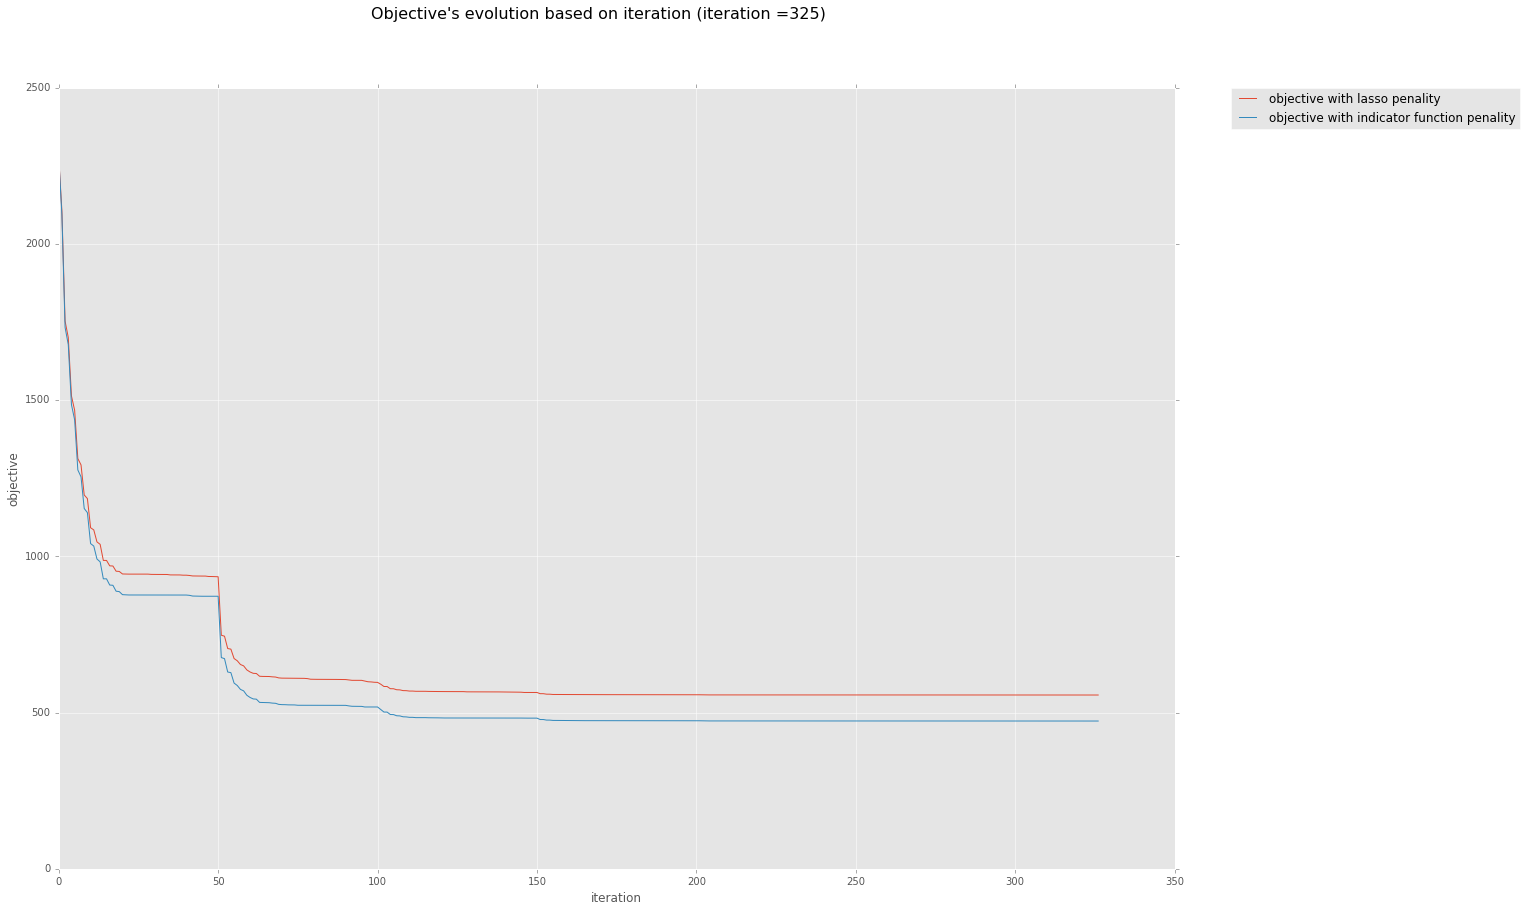

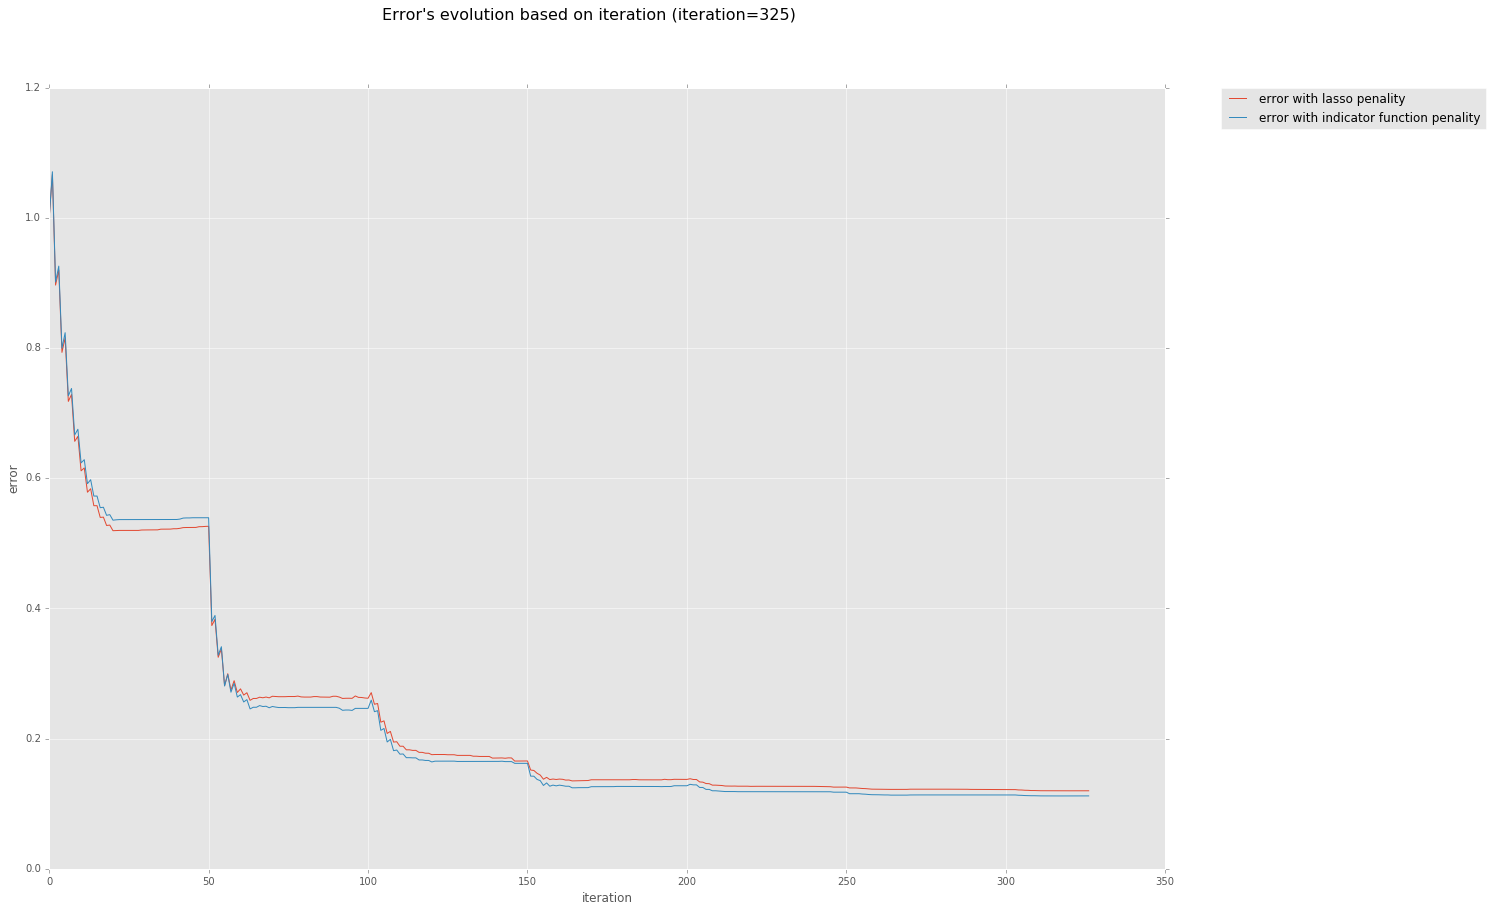

In [25]:
"""Evolution of iteration"""

"""Phase 2.1: Initialization and incrementing variables with iteration equal to 225"""
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
x0 = np.zeros(n_features)
n_iter=325
s=20

x_li, obj_li, err_li = cd_linreg(x0, A, b, lasso, prox_lasso, s , n_iter ,x_true=coefs, verbose=False)
x_ii, obj_ii, err_ii = cd_linreg(x0, A, b, indicator, prox_indicator, s, n_iter ,x_true=coefs, verbose=False)


"""Phase 2.2:  Plot observation based on iteration"""

plt.style.use('ggplot')    # sortie graphique améliorées 

    #Objective's evolution based on iteration
fig, axs = plt.subplots(figsize=(20, 14))
plt.suptitle("Objective's evolution based on iteration (iteration =%s)" % n_iter, fontsize=16)
plt.plot(np.arange(len(obj_li)),obj_li, label="objective with lasso penality ")
plt.plot(np.arange(len(obj_ii)),obj_ii, label="objective with indicator function penality")
plt.xlabel('iteration')
plt.ylabel('objective')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size':12})
plt.show()

    #Error's evolution based on iteration
fig, axs = plt.subplots(figsize=(20, 14))
plt.suptitle("Error's evolution based on iteration (iteration=%s)" % n_iter, fontsize=16)
plt.plot(np.arange(len(err_li)),err_li, label="error with lasso penality ")
plt.plot(np.arange(len(err_ii)),err_ii, label="error with indicator function penality")
plt.xlabel('iteration')
plt.ylabel('error')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size':12})

plt.show()

**Conclusion of study based on iteration**

Firstly, both graphics confirms the expected result about the same shape of coefficients but gradually fades. Indeed the performance increase between 50 and 70 iteration, and after between 100 and 120 the performance radually fades.

Secondly, objective from indicator function always better than objective's Lasso. And the gap remains constant.

Finally, 
- Between 0 to 200 iterations, the curves of error regulary inverve . Indeed, error's lasso is better between 0 and 120 iterations, while error's indicator function become better after 120 iterations.
- After 200 iterations, it seems that error's lasso is under error's indicator function.


# Bonus: Try to show that coordinate is much less affected by bad conditioning that proximal gradient descent.

**3. STUDY OF OBJECTIVE'S EVOLUTION BASED ON BAD CONDITIONNING**

We'll conduct two sub-study:
- One with the smoothing parameter equal to 0 because objective's evolution of both function is the same behavour;
- the other with the smoothing parameter different to 0.

**Assignement paramters**

We arbitrarily assign for the both sub-study:
- The number of iteration to 220, because of volatility curves beneath 200 iterations;
- The correlation will change from 0 to 0,8 (bad conditionning). 

**3.1. STUDY OF OBJECTIVE'S EVOLUTION BASED ON BAD CONDITIONNING WITH SMOOTHING PARAMETER EQUAL TO 0**

**Indication**

we use lasso function.


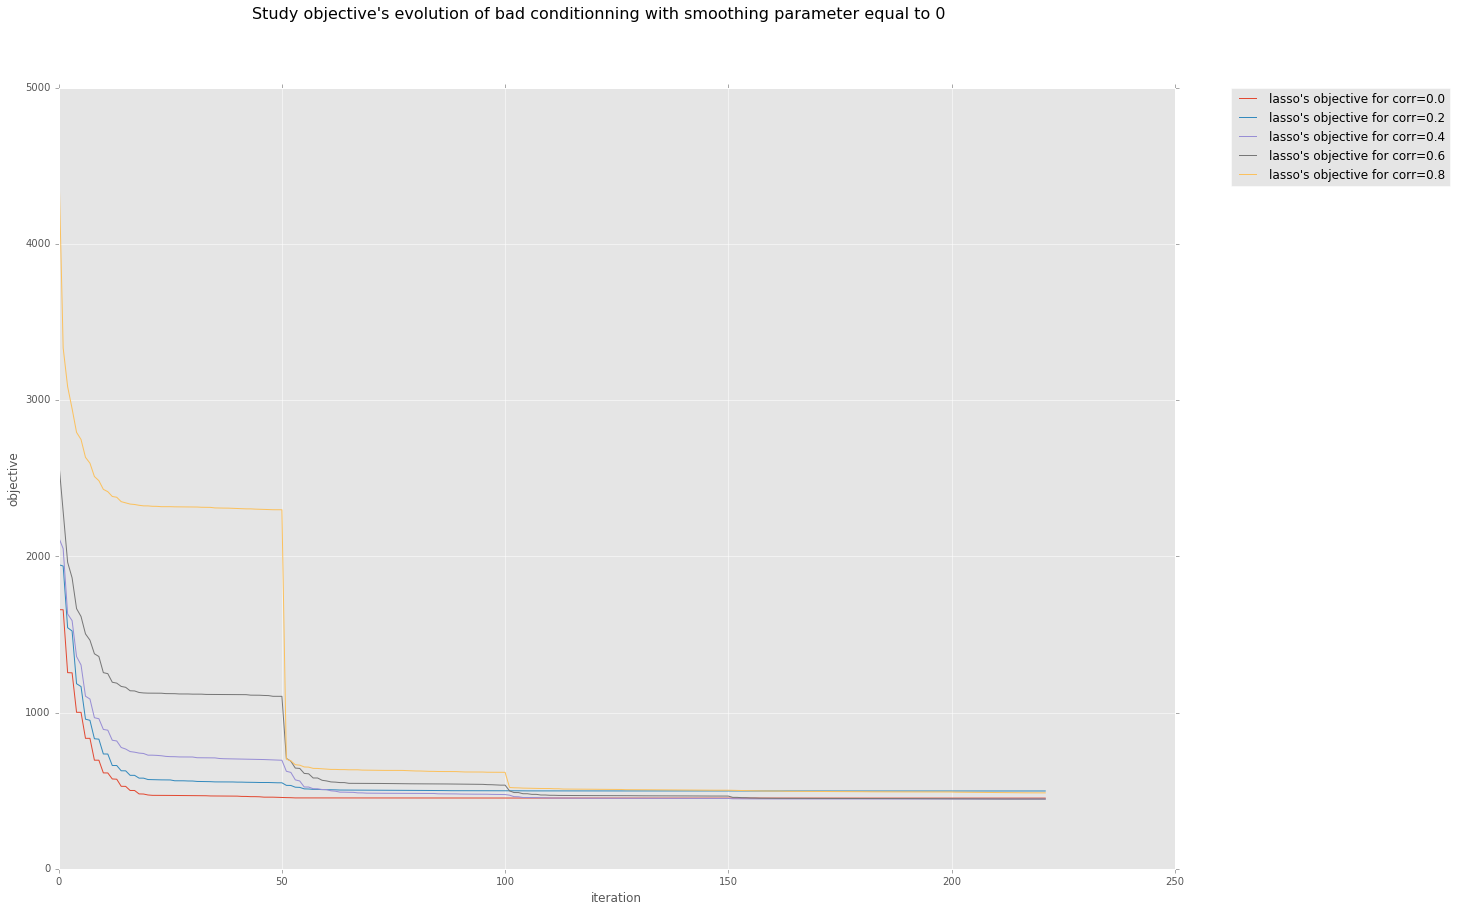

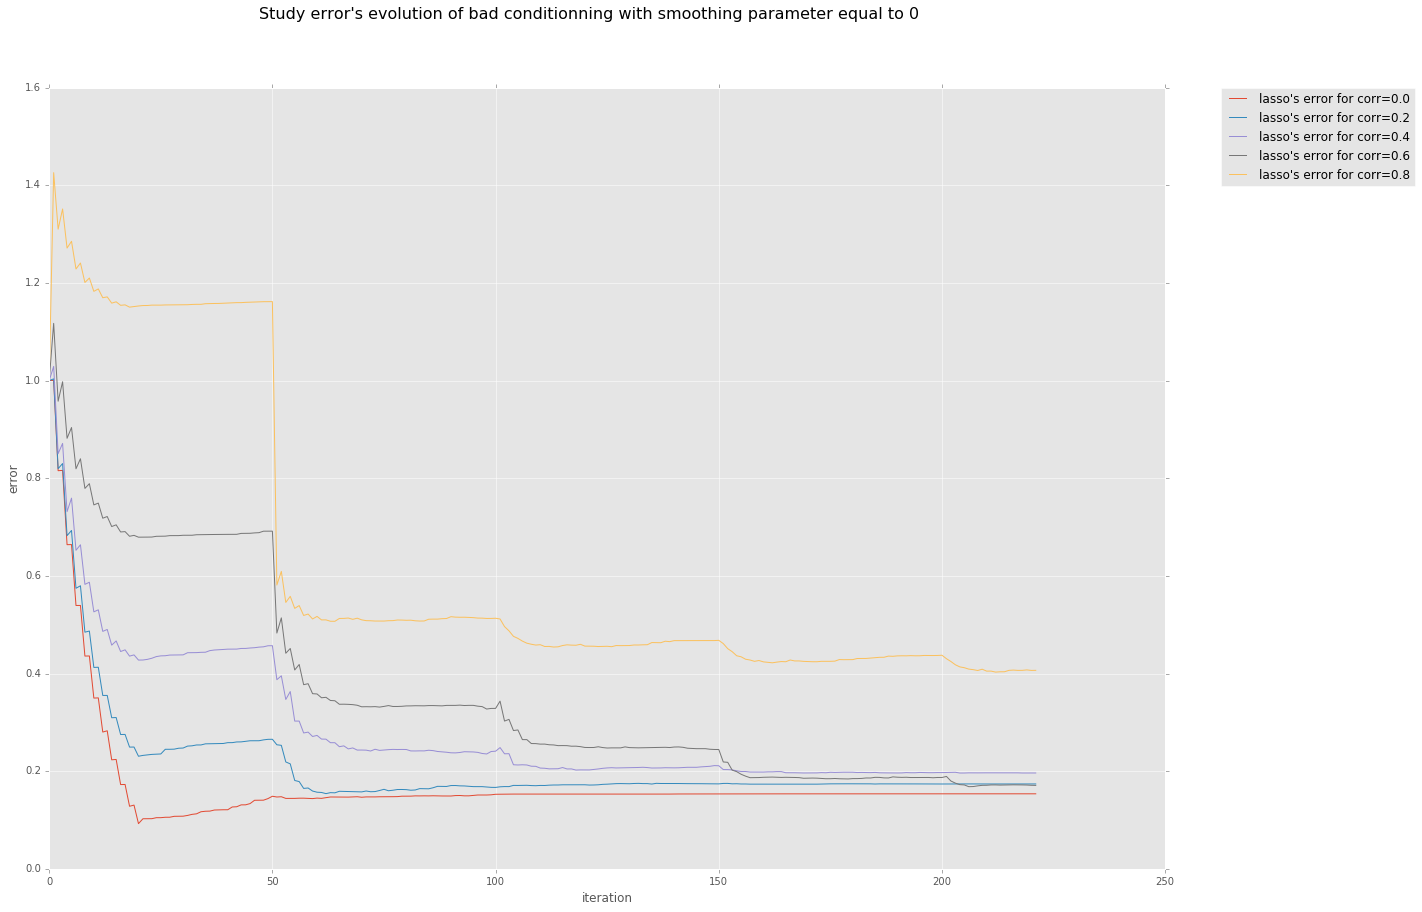

In [26]:
"""Evolution based on bad conditionning with smoothing parameter equal to 0"""

"""Phase 3.1.1: Initialization"""

k=5
x0 = np.zeros(n_features)
s=0.
n_iter=220

obj_l  = np.array([])
err_l  = np.array([])
obj_i  = np.array([])
err_i  = np.array([])

obj_li  = np.array([])
err_li  = np.array([])
obj_ii  = np.array([])
err_ii  = np.array([])


"""Phase 3.1.2: Incrementing variables"""

for i in range(k):
    corre= i/k
    
    A, b = simu_linreg(coefs, n_samples=1000 , corr=corre)
    x_li, obj_li, err_li = cd_linreg(x0, A, b, lasso, prox_lasso, s , n_iter ,x_true=coefs, verbose=False)
        
    obj_l=np.append(obj_l,obj_li)
    err_l=np.append(err_l,err_li)
 

err_l = err_l.reshape(k,len(err_li)).T
obj_l = obj_l.reshape(k,len(obj_li)).T


"""Phase 3.1.3: Plot observation based on bad conditionning with smoothing parameter equal to 0"""

    # Graphic objective function
fig, axs = plt.subplots(figsize=(20, 14))
plt.suptitle("Study objective's evolution of bad conditionning with smoothing parameter equal to 0", fontsize=16)
plt.xlabel('iteration')
plt.ylabel('objective')

for i in range(k):
    corre= i/k
    plt.plot(np.arange(len(obj_l[:,i])),obj_l[:,i], label="lasso's objective for corr=%s" %corre)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size':12})
plt.show()

    # Graphic error function
fig, axs = plt.subplots(figsize=(20, 14))
plt.suptitle("Study error's evolution of bad conditionning with smoothing parameter equal to 0", fontsize=16)
plt.xlabel('iteration')
plt.ylabel('error')

for i in range(k):
    corre= i/k
    plt.plot(np.arange(len(err_l[:,i])),err_l[:,i], label="lasso's error for corr=%s" %corre)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size':12})
plt.show()

**Conclusion of sub-study based on bad conditionning with smoothing parameter equal to 0**

The performance of algorithm is better when the correlation is lowest. This is the expected result as the previous TP.
In pratice, we must avoid high correlations between features.

**3.2. STUDY OF OBJECTIVE'S EVOLUTION BASED ON BAD CONDITIONNING WITH SMOOTHING PARAMETER DIFFERENT TO 0**

**Indication**

We arbitrarily assign the smoothing parameter to 20.

C:\Users\Olivier\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


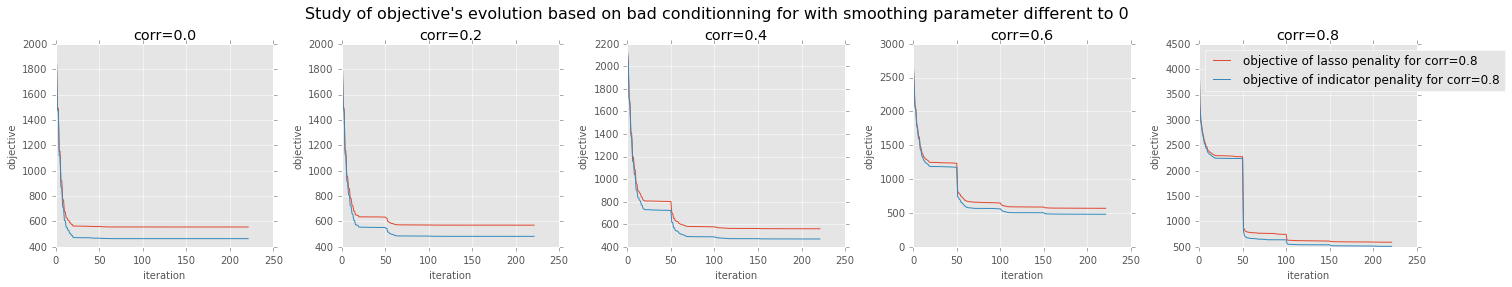

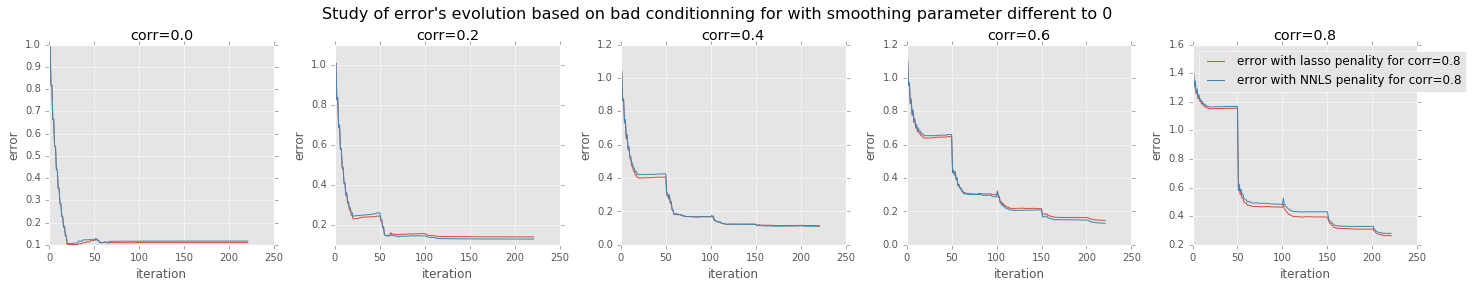

In [15]:
"""Evolution based on bad conditionning with smoothing parameter different to 0"""

"""Phase 3.2.1: Initialization"""

k=5
x0 = np.zeros(n_features)
s=20
n_iter=220


"""Phase 3.2.2: Incrementing variables and plot observation based on bad conditionning with smoothing parameter different to 0"""

    # Graphic objective functions
fig, axs = plt.subplots(ncols=k, figsize=(20, 4))
plt.suptitle("Study of objective's evolution based on bad conditionning for with smoothing parameter different to 0", fontsize=16)

for i in range(k):
    corre= i/k
    A, b = simu_linreg(coefs, n_samples=1000 , corr=corre)
    x_l, obj_l, err_l = cd_linreg(x0, A, b, lasso, prox_lasso, s , n_iter ,x_true=coefs, verbose=False)
    x_i, obj_i, err_i = cd_linreg(x0, A, b, indicator, prox_indicator, s, n_iter ,x_true=coefs, verbose=False)
    
    axs.flat[i].plot(np.arange(len(obj_l)),obj_l, label="objective of lasso penality for corr=%s" %corre)
    axs.flat[i].plot(np.arange(len(obj_i)),obj_i, label="objective of indicator penality for corr=%s" %corre)
    axs.flat[i].set_xlabel("iteration",fontsize = 10)
    axs.flat[i].set_ylabel("objective",fontsize = 10)
    axs.flat[i].set_title("corr=%s" %corre)
    plt.legend(loc=2,prop={'size':12})
# Pour espacer les schémas  
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


    # Graphic error functions
fig, axs = plt.subplots(ncols=k, figsize=(20, 4))
plt.suptitle("Study of error's evolution based on bad conditionning for with smoothing parameter different to 0", fontsize=16)

for i in range(k):
    corre= i/k    
    A, b = simu_linreg(coefs, n_samples=1000 , corr=corre)
    x_l, obj_l, err_l = cd_linreg(x0, A, b, lasso, prox_lasso, s , n_iter ,x_true=coefs, verbose=False)
    x_i, obj_i, err_i = cd_linreg(x0, A, b, indicator, prox_indicator, s, n_iter ,x_true=coefs, verbose=False)
    
    axs.flat[i].plot(np.arange(len(err_l)),err_l, label="error with lasso penality for corr=%s" %corre)
    axs.flat[i].plot(np.arange(len(err_i)),err_i, label="error with NNLS penality for corr=%s" %corre)
    axs.flat[i].set_xlabel('iteration')
    axs.flat[i].set_ylabel('error')
    axs.flat[i].set_title("corr=%s" %corre)
    plt.legend(loc=2,prop={'size':12})
# Pour espacer les schémas  
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


**Conclusion of sub-study based on bad conditionning with smoothing parameter different to 0**

Firstly, both functions show that over the correlation increases, the performence increases stepwise. 

Secondly, objective from indicator function always better than objective's Lasso, and the gap decreases as the correlation increases.

Finally, the curves of error regulary inverve based on correlation.